Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


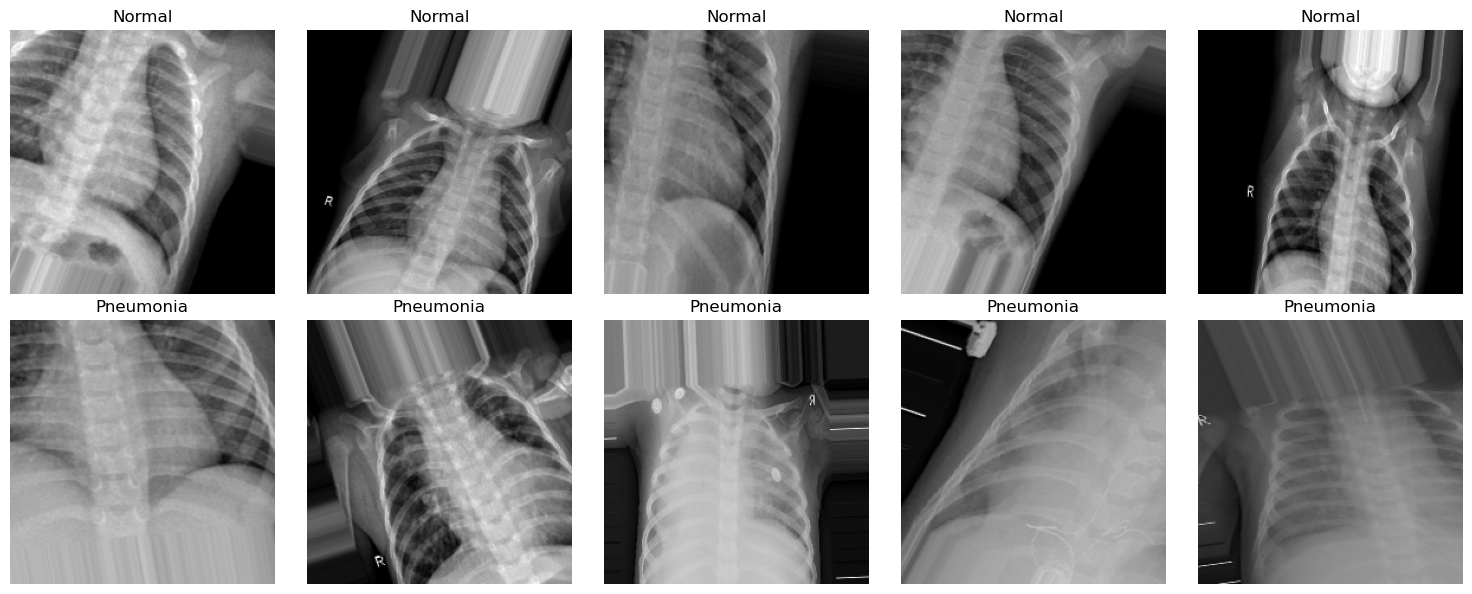

Epoch 1/50


/Users/gagan/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 410s 3s/step - accuracy: 0.7007 - loss: 0.6495 - val_accuracy: 0.7430 - val_loss: 0.5526 - learning_rate: 1.0000e-04
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 456s 3s/step - accuracy: 0.7863 - loss: 0.4473 - val_accuracy: 0.7498 - val_loss: 0.7476 - learning_rate: 1.0000e-04
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 447s 3s/step - accuracy: 0.8306 - loss: 0.3947 - val_accuracy: 0.7517 - val_loss: 0.7130 - learning_rate: 1.0000e-04
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8560 - loss: 0.3391
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
131/131 ━━━━━━━━━━━━━━━━━━━━ 452s 3s/step - accuracy: 0.8560 - loss: 0.3391 - val_accuracy: 0.7718 - val_loss: 0.6212 - learning_rate: 1.0000e-05
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 460s 3s/step - accuracy: 0.8740 - loss: 0.3125 - val_accuracy: 0.9089 - val_loss: 0.2185 - learning_rate: 1.0000e-05
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 449s 3s/step - accuracy: 0.8946 - lo

33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step
              precision    recall  f1-score   support

      Normal       0.27      0.69      0.39       268
   Pneumonia       0.76      0.35      0.48       775

    accuracy                           0.44      1043
   macro avg       0.52      0.52      0.43      1043
weighted avg       0.64      0.44      0.45      1043

[[185  83]
 [505 270]]


In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

# Data Augmentation with additional techniques
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  
    width_shift_range=0.3, 
    height_shift_range=0.3, 
    shear_range=0.3, 
    zoom_range=0.4, 
    brightness_range=[0.8, 1.2], 
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    '/Users/gagan/Desktop/chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training' 
)

validation_generator = train_datagen.flow_from_directory(
    '/Users/gagan/Desktop/chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation' 
)

# Visualize some validation images before training
val_images, val_labels = next(validation_generator)

# Separate Normal and Pneumonia images
normal_images = val_images[val_labels == 0]
pneumonia_images = val_images[val_labels == 1]

# Define how many images to display per class
num_images_to_display = min(5, len(normal_images), len(pneumonia_images)) 

# Plot Normal and Pneumonia images in two rows
fig, axes = plt.subplots(2, num_images_to_display, figsize=(15, 6))

# Class names for labeling
class_names = ['Normal', 'Pneumonia']

# Display 'Normal' images in the first row
for i in range(num_images_to_display):
    ax = axes[0, i]
    ax.imshow(normal_images[i])
    ax.set_title('Normal')
    ax.axis('off')

# Display 'Pneumonia' images in the second row
for i in range(num_images_to_display):
    ax = axes[1, i]
    ax.imshow(pneumonia_images[i])
    ax.set_title('Pneumonia')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Load ResNet50 and fine-tune
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)  # Added Batch Normalization
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze fewer layers initially
for layer in base_model.layers[:50]:
    layer.trainable = False
for layer in base_model.layers[50:]:
    layer.trainable = True

# Compile the model with Adam optimizer
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks: Reduce LR on Plateau, Early Stopping, and Learning Rate Scheduler
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# Class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = dict(enumerate(class_weights))

# Train model with initial frozen layers
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[lr_reduce, early_stop, lr_scheduler],  
    class_weight=class_weights
)

# Fine-tuning: Unfreeze more layers of the base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning using SGD
model.compile(optimizer=SGD(learning_rate=1e-5, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model for additional epochs
history_finetune = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[lr_reduce, early_stop, lr_scheduler],
    class_weight=class_weights
)

# Save the fine-tuned model
model.save('/Users/gagan/Desktop/pneumonia_detection_resnet50_optimized1.h5')

# Evaluate the model on the validation set
validation_generator.reset()  # Ensure the validation data starts from the beginning
preds = model.predict(validation_generator)
preds = preds.flatten()

# Apply ROC curve analysis to find the optimal threshold
fpr, tpr, thresholds = roc_curve(validation_generator.classes, preds)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
preds_optimal = (preds > optimal_threshold).astype(int)

# Print the classification report
print(classification_report(validation_generator.classes, preds_optimal, target_names=['Normal', 'Pneumonia']))

# Print confusion matrix for detailed insights
print(confusion_matrix(validation_generator.classes, preds_optimal))

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Path to the dataset directories
test_dir ='/Users/gagan/Desktop/chest_xray/test'
# Load your model
model = load_model('/Users/gagan/Desktop/pneumonia_detection_resnet50_optimized1.h5')

# Set up data augmentation and preprocessing for the test data
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224), 
    batch_size=16,
    class_mode='binary',  
    shuffle=False 
)

# Compile the model with binary crossentropy and appropriate metrics
model.compile(optimizer='adam',
              loss='binary_crossentropy',  
              metrics=['accuracy'])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Get predictions
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32").flatten() 

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Optional: Apply ReduceLROnPlateau to improve training (if you retrain the model)
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)


Found 624 images belonging to 2 classes.


/Users/gagan/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 17s 419ms/step - accuracy: 0.9030 - loss: 0.2262
Test Loss: 0.32321545481681824
Test Accuracy: 0.870192289352417
39/39 ━━━━━━━━━━━━━━━━━━━━ 17s 419ms/step
              precision    recall  f1-score   support

      NORMAL       0.78      0.91      0.84       234
   PNEUMONIA       0.94      0.85      0.89       390

    accuracy                           0.87       624
   macro avg       0.86      0.88      0.87       624
weighted avg       0.88      0.87      0.87       624

Confusion Matrix:
[[213  21]
 [ 60 330]]


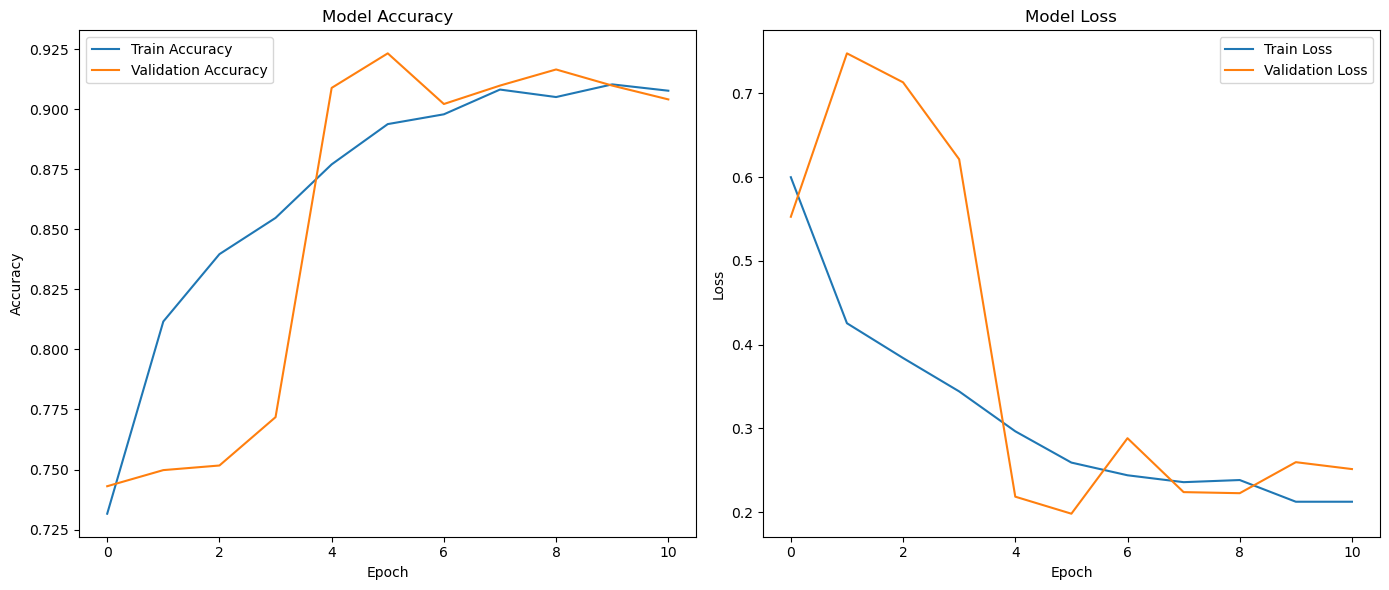

In [4]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function after training
plot_training_history(history)

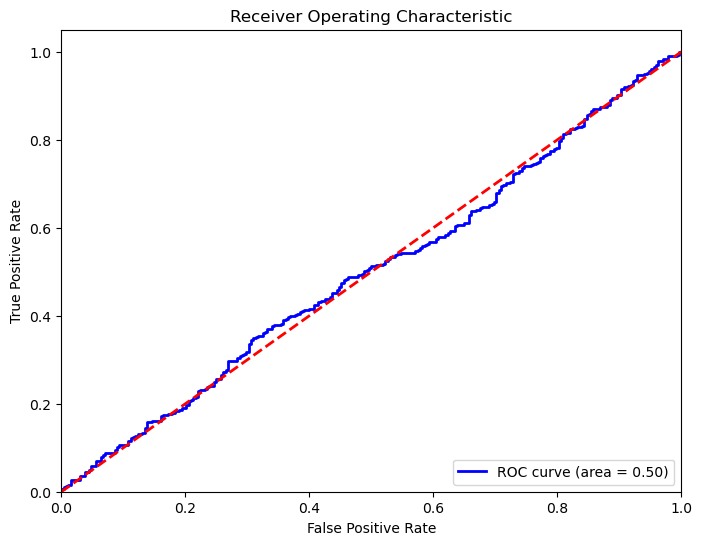

In [8]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(validation_generator.classes, preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

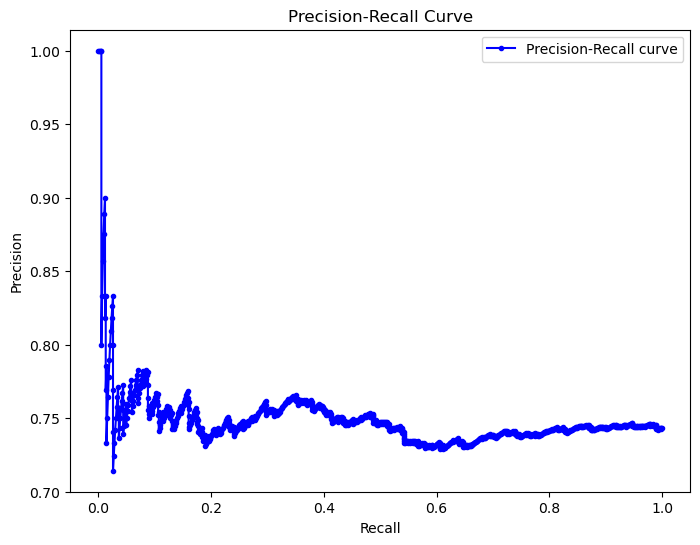

In [9]:
from sklearn.metrics import precision_recall_curve

# Compute precision and recall
precision, recall, _ = precision_recall_curve(validation_generator.classes, preds)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', color='blue', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()